# Applying LoRAs to Translation Equivariant Self-Attention in Transformers

## What is... a LoRA?

LoRAs or "Low Rank Adaptations" were introduced in the article [LoRA: Low-Rank Adaptation of Large Language Models](https://openreview.net/forum?id=nZeVKeeFYf9). They can be used in place of fine-tuning a neural network. We first freeze the original weights of a layer (learned weight matrix) in a neural network. For example, the query, key, or value weight matrix of the attention mechanism in a transformer might be frozen. We often denote these by $W_Q, W_K$, and $W_V$. We then add in a LoRA layer for one or more of these weight learned matrices. Suppose $W$ is a frozen weight matrix. Then, a LoRA layer will have the form $W + \Delta W$, where $\Delta W = BA$ is the LoRA. Usually, these are low rank decompositions, with $A \in \mathbb{R}^{d_{in} \times r}$ and $B \in \mathbb{R}^{r \times d_{out}}$, where the original weight matrix is $W \in \mathbb{R}^{d_{out} \times d_{in}}$. Usually, we have $r << \min\{d_{in}, d_{out}\}$. If the rank is not much smaller than the input and output dimension, there is little benefit in applying a LoRA. Hpwever, we can still choose an $r << \min\{d_{in}, d{out}\}$ and apply a LoRA in place of fine tuning. It is shown empirically that in many cases choosing $r = 4$ or $8$ is sufficient even for very large weight matrices such as the query, key, and value matrices of the attention mechanism in a transformer. Let's first look at an example where there is no real benefit (in terms of reduction in parameters) in applying a LoRA: 

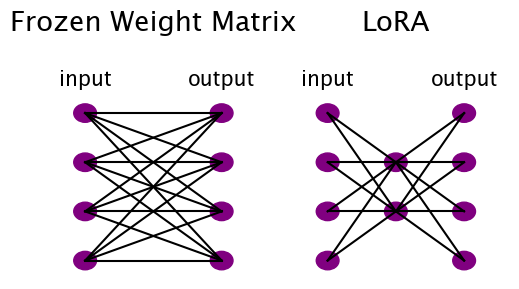

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def draw_layer(ax, position, num_nodes, layer_name, y_positions=None, color='purple'):
    if y_positions is None:
        y_positions = np.linspace(0.1, 0.9, num_nodes)
    for i in y_positions:
        ax.add_artist(plt.Circle((position, i), 0.05, color=color))
    ax.text(position, 1.05, layer_name, fontsize=15, ha='center')

def draw_connections(ax, y_positions_source, y_positions_target, pos_layer_1, pos_layer_2):
    for i in y_positions_source:
        for j in y_positions_target:
            ax.add_artist(plt.Line2D((pos_layer_1, pos_layer_2), (i, j), color='black'))

fig, axs = plt.subplots(1, 2, figsize=(5, 3))

# Draw the Frozen Weight Matrix network
y_positions_input = np.linspace(0.1, 0.9, 4)

draw_layer(axs[0], 0.2, 4, 'input', y_positions_input)
draw_layer(axs[0], 0.8, 4, 'output', y_positions_input)

draw_connections(axs[0], y_positions_input, y_positions_input, 0.2, 0.8)

axs[0].set_xlim(0, 1)
axs[0].set_ylim(0, 1.2)
axs[0].axis('off')
axs[0].set_title('Frozen Weight Matrix', fontsize=20, pad=20)

# Draw the LoRA network
y_positions_hidden = y_positions_input[1:3]  # Take the middle two positions of the input layer for the hidden layer

draw_layer(axs[1], 0.2, 4, 'input', y_positions_input)
draw_layer(axs[1], 0.5, 2, '', y_positions_hidden)
draw_layer(axs[1], 0.8, 4, 'output', y_positions_input)

draw_connections(axs[1], y_positions_input, y_positions_hidden, 0.2, 0.5)
draw_connections(axs[1], y_positions_hidden, y_positions_input, 0.5, 0.8)

axs[1].set_xlim(0, 1)
axs[1].set_ylim(0, 1.2)
axs[1].axis('off')
axs[1].set_title('LoRA', fontsize=20, pad=20)

plt.tight_layout()
plt.show()



Here, we see that the number of parameters for the LoRA layer $\Delta W = BA$ is the same as the original layer $W$, where we have $4 \times 2 \times 2 = 16$ parameters for the LoRA (on the right), and $4 \times 4 = 16$ parameters for the original frozen weight matrix (on the left). Next, let's look at an example that gives us $40\%$ the parameters of the frozen weight matrix: 

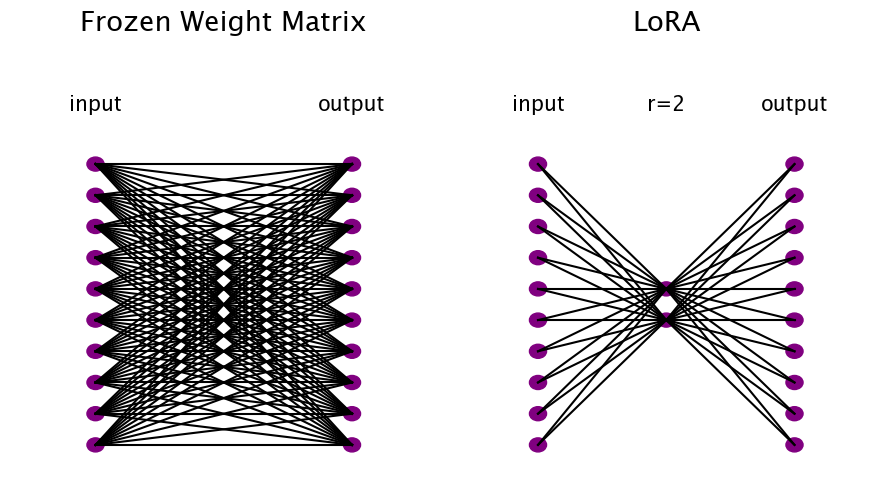

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def draw_layer(ax, position, num_nodes, layer_name, y_positions=None, color='purple'):
    if y_positions is None:
        y_positions = np.linspace(0.1, 0.9, num_nodes)
    for i in y_positions:
        ax.add_artist(plt.Circle((position, i), 0.02, color=color))
    ax.text(position, 1.05, layer_name, fontsize=15, ha='center')

def draw_connections(ax, y_positions_source, y_positions_target, pos_layer_1, pos_layer_2):
    for i in y_positions_source:
        for j in y_positions_target:
            ax.add_artist(plt.Line2D((pos_layer_1, pos_layer_2), (i, j), color='black'))

fig, axs = plt.subplots(1, 2, figsize=(9, 5))

# Draw the Frozen Weight Matrix network
y_positions_input = np.linspace(0.1, 0.9, 10)

draw_layer(axs[0], 0.2, 10, 'input', y_positions_input)
draw_layer(axs[0], 0.8, 10, 'output', y_positions_input)

draw_connections(axs[0], y_positions_input, y_positions_input, 0.2, 0.8)

axs[0].set_xlim(0, 1)
axs[0].set_ylim(0, 1.2)
axs[0].axis('off')
axs[0].set_title('Frozen Weight Matrix', fontsize=20, pad=20)

# Draw the LoRA network
y_positions_hidden = y_positions_input[4:6]  # Take the middle two positions of the input layer for the hidden layer

draw_layer(axs[1], 0.2, 10, 'input', y_positions_input)
draw_layer(axs[1], 0.5, 2, 'r=2', y_positions_hidden)
draw_layer(axs[1], 0.8, 10, 'output', y_positions_input)

draw_connections(axs[1], y_positions_input, y_positions_hidden, 0.2, 0.5)
draw_connections(axs[1], y_positions_hidden, y_positions_input, 0.5, 0.8)

axs[1].set_xlim(0, 1)
axs[1].set_ylim(0, 1.2)
axs[1].axis('off')
axs[1].set_title('LoRA', fontsize=20, pad=20)

plt.tight_layout()
plt.show()


Here we see the original (frozen) weight matrix has $10^2$ parameters, and the LoRA has only $10 \times 2 \times 2 = 40$ parameters. In most cases, we have that the rank (ideally this is the number of neurons in the middle layer of the LoRA) of the frozen matrix is much smaller than the input and output dimensions, and there is in fact a drastic reduction in parameter count. As an example, we might have an input and output dimension of say $100$, in which case the weight matrix has $100^2 = 10,000$ parameters. However, the rank of this matrix is very often much lower than $100$. In practice, it was shown that choosing $r = 4$ for the query, key, and value matrices is often more than sufficient for a LoRA as the middle dimension. In this case, we would get $100 \times 4 \times 2 = 800$ parameters in the LoRA, which is less than one tenth the original parameter count. Once we have such a LoRA in place, we can train it on seom downstream task, and then add the LoRA weight matrix $BA$ to the original (frozen) weight matrix $W$ to obtain a model that performs well on this new task. Now, let us look at how LoRAs can be added into a translation equivariant attention mechanism without any loss of translation equivariance. 

## Including LoRAs Does Not Disrupt Equivariance

In the following proof, we follow notation very similar to [Group Equivariant Stand-Alone Self-Attention For Vision](https://openreview.net/forum?id=JkfYjnOEo6M&noteId=dxKhFZNxn-D). Suppose we are given an input matrix $X \in \mathbb{R}^{d_{in} \times d}$, with columns representing the embedding vectors of $d$ tokens. We can formulate the self-attention matrix in a transformer with relative positional encoding as 

\begin{equation}
A_{i, j} =  (W_QX)(W_K(X+P_{x(j)-x(i)}))^T 
\end{equation}

We leave out the scaling factor $1/\sqrt{d_k}$ for simplicity, but it can easily be included without disrupting any of our arguments or proofs. It will be more beneficial for our purposes to formulate self-attention in a function theoretic way. In particular, we can view the input matrix $X$ as a vector valued function $f:S \to \mathbb{R}^{d_{in}}$, that is $f \in L_{\mathbb{R}^{d_{in}}}(S)$, for the index set $S = \{1, 2, ..., d\}$. We then view the query and key matrices as maps $\varphi_{qry}: L_{\mathbb{R}^{d_{in}}}(S) \to L_{\mathbb{R}^{d_k}}(S)$ and $\varphi_{key}: L_{\mathbb{R}^{d_{in}}}(S) \to L_{\mathbb{R}^{d_k}}(S)$. There is also a value function $\varphi_{val}: L_{\mathbb{R}^{d_{in}}}(S) \to L_{\mathbb{R}^{d_v}}(S)$. With these in hand, we can express the attention map with positional encoding as
\begin{equation}
A_{i, j} = \alpha[f](i, j) = \langle \varphi_{qry}(f(i)), \varphi_{key}(f(j) + \rho(i, j))\rangle
\end{equation}

Here, we have written $\rho(i, j)$ for the positional encoding. The map $\alpha[f]:S \times S \to \mathbb{R}$ maps pairs of elements $i, j \in S$ to the attention score of $j$ relative to $i$. We can then write the attention mechanism as 

\begin{equation}
\zeta[f](i) = \sum_{j \in S} \sigma_j\left( \alpha[f](i, j) \right)\varphi_{val}(f(j))
\end{equation}

Next, we would like to include a LoRA for the query, key, and value maps. We will formulate this as 

\begin{equation}
\Delta\varphi_{qry}(f(i)) = (\varphi^{A}_{qry} \circ \varphi^{B}_{qry})(f(i)) = \varphi^B_{qry}(\varphi^A_{qry}(f(i)))
\end{equation}

\begin{equation}
\Delta\varphi_{key}(f(i)) = (\varphi^{A}_{key} \circ \varphi^{B}_{key})(f(i)) = \varphi^B_{key}(\varphi^A_{key}(f(i)))
\end{equation}

\begin{equation}
\Delta\varphi_{val}(f(i)) = (\varphi^{A}_{val} \circ \varphi^{B}_{val})(f(i)) = \varphi^B_{val}(\varphi^A_{val}(f(i)))
\end{equation}

Here, we have 

\begin{align}
\varphi^A_{qry}: L_{\mathbb{R}^{d_k}}(S) \to L_{\mathbb{R}^{r(A)}}(S) &\quad \quad \varphi^B_{qry}: L_{\mathbb{R}^{r(A)}}(S) \to L_{\mathbb{R}^{d_k}}(S) \\
\varphi^A_{key}: L_{\mathbb{R}^{d_k}}(S) \to L_{\mathbb{R}^{r(A)}}(S) &\quad \quad \varphi^B_{key}: L_{\mathbb{R}^{r(A)}}(S) \to L_{\mathbb{R}^{d_k}}(S) \\
\varphi^A_{val}: L_{\mathbb{R}^{d_v}}(S) \to L_{\mathbb{R}^{r(A)}}(S) &\quad \quad \varphi^B_{val}: L_{\mathbb{R}^{r(A)}}(S) \to L_{\mathbb{R}^{d_v}}(S) 
\end{align}

Next, including this in the attention mechanism, we get

\begin{equation}
\alpha^{LoRA}[f](i, j) = \langle \varphi_{qry}(f(i))+ \Delta\varphi_{qry}(f(i)), \varphi_{key}(f(j) + \rho(i, j)) + \Delta\varphi_{key}(f(j) + \rho(i, j))\rangle
\end{equation}

and then 

\begin{equation}
\zeta^{LoRA}[f](i) = \sum_{j \in S} \sigma_j\left( \alpha^{LoRA}[f](i, j) \right)(\varphi_{val}(f(j))+ \Delta\varphi_{val}(f(j)))
\end{equation}

Now, in order to have translation equivariance of a LoRA multihead self-attention with relative positional encoding, we need the following equation to hold, 

\begin{equation}
m^r_{LoRA}[L_y[f], \rho](i) = L_y[m^r_{LoRA}[f, \rho]](i)
\end{equation}

where $L_y[f](i) = f(x^{-1}(x(i)-y))$. The LoRA multihead self-attention with relative positional encodings on $L_y[f]$ is given by


\begin{align}
m^r_{LoRA}[L_y[f], \rho](i) &= \varphi_{out}\Bigg( \bigcup_{h \in [H]} \sum_{j \in N(i)} \sigma_j \Bigg( \Big\langle \varphi_{qry}^{(h)}(L_y[f](i)) + \Delta\varphi_{qry}^{(h)}(f(i)), \\
&\quad \varphi_{key}^{(h)}(L_y[f](j)+\rho(i, j)) + \Delta\varphi_{key}^{(h)}(f(j)+\rho(i, j)) \Big\rangle\Bigg) \Bigg)\Bigg(\varphi_{val}^{(h)}(L_y[f](j)) + \Delta\varphi_{val}^{(h)}(f(j)) \Bigg)\\
&= \varphi_{out}\Bigg( \bigcup_{h \in [H]} \sum_{j \in N(i)} \sigma_j \Bigg( \Big\langle \varphi_{qry}^{(h)}(f(x^{-1}(x(i)-y))) + \Delta\varphi_{qry}^{(h)}(f(x^{-1}(x(i)-y))), \\
&\quad \varphi_{key}^{(h)}(f(x^{-1}(x(j)-y))+\rho(i, j)) + \Delta\varphi_{key}^{(h)}(f(x^{-1}(x(j)-y))+\rho(i, j)) \Big\rangle\Bigg) \Bigg)\Bigg(\varphi_{val}^{(h)}(f(x^{-1}(x(j)-y))) + \Delta\varphi_{val}^{(h)}(f(x^{-1}(x(j)-y))) \Bigg) \\
&= \varphi_{out}\Bigg( \bigcup_{h \in [H]} \sum_{x^{-1}(x(\overline{j})+y) \in N(x^{-1}(x(\overline{i})+y))} \sigma_{x^{-1}(x(\overline{j})+y)} \Bigg( \Big\langle \varphi_{qry}^{(h)}(f(\overline{i})) + \Delta\varphi_{qry}^{(h)}(f(\overline{i})), \\
&\quad \varphi_{key}^{(h)}(f(\overline{j})+\rho(x^{-1}(x(\overline{i})+y), x^{-1}(x(\overline{j})+y))) + \Delta\varphi_{key}^{(h)}(f(\overline{j})+\rho(x^{-1}(x(\overline{i})+y), x^{-1}(x(\overline{j})+y))) \Big\rangle\Bigg) \Bigg)\Bigg(\varphi_{val}^{(h)}(f(\overline{j})) + \Delta\varphi_{val}^{(h)}(f(\overline{j})) \Bigg)
\end{align}

Here we have used the substitution $\overline{i} = x^{-1}(x(i)-y) \implies i = x^{-1}(x(\overline{i})+y)$ and $\overline{j} = x^{-1}(x(j)-y) \implies j = x^{-1}(x(\overline{j})+y)$. We can further reduce the equations using the defintion of $\rho(i, j) = \rho^P(x(j) - x(i))$:

\begin{align}
&= \varphi_{out}\Bigg( \bigcup_{h \in [H]} \sum_{x^{-1}(x(\overline{j})+y) \in N(x^{-1}(x(\overline{i})+y))} \sigma_{x^{-1}(x(\overline{j})+y)} \Bigg( \Big\langle \varphi_{qry}^{(h)}(f(\overline{i})) + \Delta\varphi_{qry}^{(h)}(f(\overline{i})), \\
&\quad \varphi_{key}^{(h)}(f(\overline{j})+\rho^P(x(\overline{j}) + y - (x(\overline{i})+y))) + \Delta\varphi_{key}^{(h)}(f(\overline{j})+\rho^P(x(\overline{j}) + y - (x(\overline{i})+y))) \Big\rangle\Bigg) \Bigg)\Bigg(\varphi_{val}^{(h)}(f(\overline{j})) + \Delta\varphi_{val}^{(h)}(f(\overline{j})) \Bigg)\\
&= \varphi_{out}\Bigg( \bigcup_{h \in [H]} \sum_{x^{-1}(x(\overline{j})+y) \in N(x^{-1}(x(\overline{i})+y))} \sigma_{x^{-1}(x(\overline{j})+y)} \Bigg( \Big\langle \varphi_{qry}^{(h)}(f(\overline{i})) + \Delta\varphi_{qry}^{(h)}(f(\overline{i})), \\
&\quad \varphi_{key}^{(h)}(f(\overline{j})+\rho^P(x(\overline{j}) - x(\overline{i}))) + \Delta\varphi_{key}^{(h)}(f(\overline{j})+\rho^P(x(\overline{j}) - x(\overline{i}))) \Big\rangle\Bigg) \Bigg)\Bigg(\varphi_{val}^{(h)}(f(\overline{j})) + \Delta\varphi_{val}^{(h)}(f(\overline{j})) \Bigg)\\
&= \varphi_{out}\Bigg( \bigcup_{h \in [H]} \sum_{x^{-1}(x(\overline{j})+y) \in N(x^{-1}(x(\overline{i})+y))} \sigma_{x^{-1}(x(\overline{j})+y)} \Bigg( \Big\langle \varphi_{qry}^{(h)}(f(\overline{i})) + \Delta\varphi_{qry}^{(h)}(f(\overline{i})), \\
&\quad \varphi_{key}^{(h)}(f(\overline{j})+\rho(\overline{i}, \overline{j})) + \Delta\varphi_{key}^{(h)}(f(\overline{j})+\rho(\overline{i}, \overline{j})) \Big\rangle\Bigg) \Bigg)\Bigg(\varphi_{val}^{(h)}(f(\overline{j})) + \Delta\varphi_{val}^{(h)}(f(\overline{j})) \Bigg)
\end{align}

For any translation $y \in \mathbb{R}^{d_{in}}$, where $d_{in}$ is the dimension of $f(i)$ and $f(j)$, the summation remains the same, so we have:

\begin{equation}
\sum_{x^{-1}(x(\overline{j})+y) \in N(x^{-1}(x(\overline{i})+y))}[\bullet] = \sum_{x^{-1}(x(\overline{j})) \in N(x^{-1}(x(\overline{i})))}[\bullet] = \sum_{\overline{j} \in N(\overline{i})}[\bullet]
\end{equation}

As we can see, $m^r_{LoRA}[L_y[f], \rho](i) = L_y[m^r_{LoRA}[f, \rho]](i)$. We can thus conclude that relative positional encodings, coupled with LoRAs for the query, key, and value weight matrices gives a translation equivariant multihead self-attention mechanism. In particular, addition of LoRAs in a translation equivariant model with relative positional encodings does not disrupt the translation equivariance. 


which means we can further reduce the expression as

\begin{align}
m^r_{LoRA}[L_y[f], \rho](i) &= \varphi_{out}\Bigg( \bigcup_{h \in [H]} \sum_{x^{-1}(x(\overline{j})+y) \in N(x^{-1}(x(\overline{i})+y))} \sigma_{x^{-1}(x(\overline{j})+y)} \Bigg( \Big\langle \varphi_{qry}^{(h)}(f(\overline{i})) + \Delta\varphi_{qry}^{(h)}(f(\overline{i})), \\
&\quad \varphi_{key}^{(h)}(f(\overline{j})+\rho(\overline{i}, \overline{j})) + \Delta\varphi_{key}^{(h)}(f(\overline{j})+\rho(\overline{i}, \overline{j})) \Big\rangle\Bigg) \Bigg)\Bigg(\varphi_{val}^{(h)}(f(\overline{j})) + \Delta\varphi_{val}^{(h)}(f(\overline{j})) \Bigg)\\
&= m^r_{LoRA}[f, \rho](\overline{i})\\
&= m^r_{LoRA}[f, \rho](x^{-1}(x(i)-y))\\
&= L_y[m^r_{LoRA}[f, \rho]](i)
\end{align}